In [1]:
pip install -U lightautoml

     |████████████████████████████████| 262 kB 862 kB/s 
     |████████████████████████████████| 420 kB 7.7 MB/s 
     |████████████████████████████████| 232 kB 19.6 MB/s 
     |████████████████████████████████| 1.2 MB 20.0 MB/s 
     |████████████████████████████████| 204 kB 39.8 MB/s 
     |████████████████████████████████| 2.9 MB 54.8 MB/s 
     |████████████████████████████████| 90 kB 7.0 MB/s 
     |████████████████████████████████| 94 kB 1.9 MB/s 
     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 121 kB 49.3 MB/s 
     |████████████████████████████████| 100 kB 7.7 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=6e0edbcf3dcbbcf9c60e8c276c00a8efc2d1a2a64256ba3d856afb7a1013d2d8
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for json2html:

# Load dependencies

In [2]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

import torch
from sklearn.metrics import f1_score, roc_auc_score, log_loss

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task

# Everything for graphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('../input/porto-seguro-data-challenge/train.csv', index_col='id')
train_id = train.index
train = train.reset_index(drop=True)
test = pd.read_csv('../input/porto-seguro-data-challenge/test.csv', index_col='id').reset_index(drop=True)
sample_submission = pd.read_csv('../input/porto-seguro-data-challenge/submission_sample.csv')
meta = pd.read_csv('../input/porto-seguro-data-challenge/metadata.csv')

In [4]:
# Add predictions from other models

train.loc[:,'cat_pseudo'] = pd.read_csv('../input/porto-seguro-catboost-pseudolabel/cat_pseudo_oof.csv').cat_pseudo_oof
test.loc[:,'cat_pseudo'] = pd.read_csv('../input/porto-seguro-catboost-pseudolabel/cat_pseudo_sub_probs.csv').predicted

train.loc[:,'cat_knn_shap'] = pd.read_csv('../input/porto-seguro-catboost-knn-shap/cat_oof.csv').cat_shap_oof
test.loc[:,'cat_knn_shap'] = pd.read_csv('../input/porto-seguro-catboost-knn-shap/cat_shap_sub_probs.csv').predicted

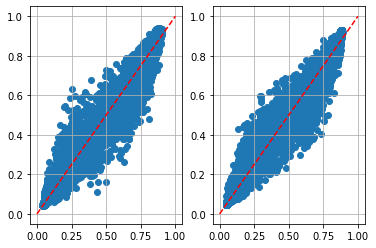

<Figure size 360x432 with 0 Axes>

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)

plt.figure(figsize = (5, 6))
ax1.scatter(train['cat_pseudo'], train['cat_knn_shap'])
ax1.plot([0, 1], [0, 1], '--r')
ax1.grid(True)
#ax1.title('Train data: cat_pseudo vs cat_knn_shap preds', fontsize = 17)
#ax1.xlabel('cat_pseudo', fontsize = 17)
#ax1.ylabel('cat_knn_shap', fontsize = 17)


ax2.scatter(test['cat_pseudo'], test['cat_knn_shap'])
ax2.plot([0, 1], [0, 1], '--r')
ax2.grid(True)
#ax2.title('Test data: cat_pseudo vs cat_knn_shap preds', fontsize = 17)
#ax2.xlabel('cat_pseudo', fontsize = 17)
#ax2.ylabel('cat_knn_shap', fontsize = 17)
plt.show()

In [6]:
# Create new features
for data in [train, test]:
    data['cat_pseudo_minus_cat_knn_shap'] = data['cat_pseudo'] - data['cat_knn_shap']
    data['cat_pseudo_mul_cat_knn_shap']   = data['cat_pseudo'] * data['cat_knn_shap']
    data['cat_pseudo_div_cat_knn_shap']   = data['cat_pseudo'] / data['cat_knn_shap']

In [7]:
def get_threshold(y_true, y_pred):
    # Moving threshold
    thresholds = np.arange(0.0, 1.0, 0.01)
    f1_scores = []
    for thresh in thresholds:
        f1_scores.append(
            f1_score(y_true, [1 if m>thresh else 0 for m in y_pred]))
    f1s = np.array(f1_scores)
    return thresholds[f1s.argmax()]
    
    
def custom_f1(y_true, y_pred):
     
    max_f1_threshold =  get_threshold(y_true, y_pred)

    y_pred = np.where(y_pred>max_f1_threshold, 1, 0)
    f1_after = f1_score(y_true, y_pred) 
    
    return f1_after

# LightAutoML

In [8]:
%%time 

N_THREADS = 4 
N_FOLDS = 10
SEED = 5
TIMEOUT = 60 * 60 * 8
TARGET_NAME = 'y'

np.random.seed(SEED)
torch.set_num_threads(N_THREADS)

task = Task('binary', metric = roc_auc_score, greater_is_better=True)

roles = {
    'target': 'y'
}

automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       general_params = {'use_algos': [['lgb', 'lgb_tuned', 'cb', 'cb_tunned'], 
                                                       ['linear_l2', 'lgb_tuned']]},
                       reader_params = {'n_jobs': N_THREADS})

y_oof = automl.fit_predict(train, roles = roles).data.ravel()

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 4, 'random_state': 42}
Found general_params in kwargs, need to combine
Merged variant for general_params = {'use_algos': [['lgb', 'lgb_tuned', 'cb', 'cb_tunned'], ['linear_l2', 'lgb_tuned']], 'return_all_predictions': False}
Start automl preset with listed constraints:
- time: 28799.994587659836 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (14123, 74)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 28772.998673200607 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's binary_logloss: 0.326862	valid's Opt metric: 0.876918
[200]	valid's binary_logloss: 0.32776	valid's Opt metri

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start fitting Lvl_0_Pipe_0_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's binary_logloss: 0.329804	valid's Opt metric: 0.870669
[200]	valid's binary_logloss: 0.345939	valid's Opt metric: 0.873245
[300]	valid's binary_logloss: 0.377434	valid's Opt metric: 0.873984
Early stopping, best iteration is:
[100]	valid's binary_logloss: 0.329804	valid's Opt metric: 0.870669
Lvl_0_Pipe_0_Mod_1_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's binary_logloss: 0.327146	valid's Opt metric: 0.878292
[200]	valid's binary_logloss: 0.326823	valid's Opt metric: 0.876194
Early stopping, best iteration is:
[7]	valid's binary_logloss: 0.455719	valid's Opt metric: 0.880174
Lvl_0_Pipe_0_Mod_1_LightGBM fitting

In [9]:
y_pred = automl.predict(test).data.ravel()

In [10]:
final_threshold = get_threshold(train.y, y_oof)
final_threshold

0.34

In [11]:
print("Final F1     :", custom_f1(train.y, y_oof))
print("Final AUC    :", roc_auc_score(train.y, y_oof))
print("Final LogLoss:", log_loss(train.y, y_oof))

Final F1     : 0.6816942374113798
Final AUC    : 0.89798990290416
Final LogLoss: 0.30307432134312423


# Sub

In [12]:
# Write predictions to sub
sample_submission['predicted'] = np.where(y_pred>final_threshold, 1, 0).astype('int64')
sample_submission.to_csv('lightautoml_pseudo_sub.csv',index=False)

# Write predictions to stack
sample_submission['predicted'] = y_pred
sample_submission.to_csv('lightautoml_pseudo_sub_probs.csv',index=False)
pd.DataFrame({'id':train_id, 'lightautoml_pseudo_oof':y_oof[range(14123)]}).to_csv('lightautoml_pseudo_oof.csv',index=False)